## File 02 - Feature Creation, Test/Train Split, PCA (Preprocessing Step 2)
##### Group 12:

##### Hannah Schmuckler, mmc4cv

##### Rob Schwartz, res7cd

In this file, we create new features from our interaction-level dataset, handle obvious errors, and perform PCA. We will also create a downsampled dataset for comparison. We will output 4 files:

- `processed_data/engineered_features.parquet` # This is just a raw file containing all engineered feature rows
- `processed_data/train.parquet` #Our final training set
- `processed_data/test.parquet` #Our final test set
- `processed_data/ds_train.parquet` #Our downsampled training set - to see if downsampling might help performance. 
- `processed_data/ds_test.parquet` #Our test set - with PCA from the downsampled PCA. 


### Set up Spark session and data schema

We can specify more options in the SparkSession creator, but currently the options are at the default settings.

In [3]:
%%time
from pyspark.sql import SparkSession
from pyspark.sql import types as T
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import *
import datetime as dt
from pyspark.sql.functions import translate
import pandas as pd
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.linalg import Vectors 
              
import copy
    
import sys
spark = SparkSession.builder \
        .appName("project") \
        .getOrCreate()

sc = spark.sparkContext

#schema = "`event_time` TIMESTAMP,`event_type` STRING,`product_id` INT,`category_id` BIGINT,`category_code` STRING,`brand` STRING,`price` FLOAT,`user_id` INT,`user_session` STRING"
#ddl_schema = T._parse_datatype_string(schema)

CPU times: user 974 µs, sys: 0 ns, total: 974 µs
Wall time: 919 µs


See https://docs.google.com/document/d/1NG4KGticBXn0D3PL5_zMxLV2Pr7A8PQtLcasxCOd1nA/edit for table of features.

### Read in data

In [4]:
%%time
full = spark.read.parquet("./processed_data/preprocessed_01.parquet")
m1 = spark.read.parquet("./processed_data/month_01_filtered.parquet") # This brings in the data we can create additional features from

CPU times: user 1.28 ms, sys: 1.22 ms, total: 2.51 ms
Wall time: 348 ms


In [5]:
#print(full.count()) # 359105
#full.show(5)

In [6]:
#print(m1.count()) #15923973
#m1.show(5)

## Begin Creating Features
### Create each on an individual level, then join to full
##### NOTE: Must rename all features so that they do not contain parenthesis - not compatible with saving to parquet

_________________

#### Average Session Duration (avg_session_length)

In [7]:
session_ends = m1.groupBy('user_id', 'user_session').agg(max('event_time'), min('event_time'))

In [8]:
#session_ends.show(5)

In [9]:
session_ends = session_ends.withColumn('session_length', (col("max(event_time)").cast('long') - col("min(event_time)").cast('long')))

In [10]:
#session_ends.orderBy(col("session_length").desc()).show(5)
# NOTE: Lots of these sessions are unreasonably long

In [11]:
avg_sess = session_ends.groupBy('user_id').avg('session_length').withColumnRenamed('avg(session_length)', "avg_session_length")

In [12]:
#avg_sess.show(5)

In [13]:
full = full.join(avg_sess, full.user_id == avg_sess.user_id).drop(avg_sess.user_id)
#print(full.count()) # 359105
#full.show(5)

#### Std Deviation of session duration by person (sd_session_length)

In [14]:
#session_ends.show(5)

In [15]:
sd_session_length = session_ends.groupBy('user_id') \
                                 .agg(stddev('session_length')) \
                                 .withColumnRenamed("stddev_samp(session_length)", 'sd_session_length')

In [16]:
#sd_session_length.show(5)

In [17]:
full = full.join(sd_session_length, full.user_id == sd_session_length.user_id).drop(sd_session_length.user_id)

#### Average number of interactions per session (avg_interactions_per_session)

In [18]:
interactions_per_session = m1.groupBy('user_id', 'user_session').agg(count('event_type'))

In [19]:
#interactions_per_session.show(5)

In [20]:
avg_interactions_per_session = interactions_per_session.groupBy('user_id').avg('count(event_type)')

In [21]:
avg_interactions_per_session = avg_interactions_per_session.withColumnRenamed('avg(count(event_type))', "avg_interactions_per_session")

In [22]:
full = full.join(avg_interactions_per_session, full.user_id == avg_interactions_per_session.user_id).drop(avg_interactions_per_session.user_id)
#full.show(5)

#### Std Deviation of number of interactions per session per person (sd_interactions_per_session)

In [23]:
std_interactions_per_session = interactions_per_session.groupBy('user_id') \
                                                       .agg(stddev('count(event_type)')) \
                                                       .withColumnRenamed("stddev_samp(count(event_type))", 'sd_interactions_per_session')
#std_interactions_per_session.show(5)

In [24]:
full = full.join(std_interactions_per_session, full.user_id == std_interactions_per_session.user_id).drop(std_interactions_per_session.user_id)
#full.show(5)

#### Max number of interactions within one session (max_interactions_per_session)

In [25]:
max_interactions_per_session = interactions_per_session.groupBy('user_id').max('count(event_type)')

In [26]:
max_interactions_per_session = max_interactions_per_session.withColumnRenamed('max(count(event_type))', "max_interactions_per_session")

In [27]:
#max_interactions_per_session.show(1)

In [28]:
full = full.join(max_interactions_per_session, full.user_id == max_interactions_per_session.user_id).drop(max_interactions_per_session.user_id)
#full.show(5)

#### Percent of total events that are x (Purchase, Cart, View) ('purchase_pct_of_total_events', 'cart_pct_of_total_events', 'view_pct_of_total_events')

In [29]:
event_counts = m1.groupBy('user_id', 'user_session').pivot('event_type').agg(count('event_type'))
# Here the three types of event count are pivoted out for later tabulation

In [30]:
event_counts = event_counts.fillna(0) #replace nulls with 0 for math
#event_counts.show(5)

In [31]:
events_per_session = event_counts.withColumn('events_per_session_total', col('cart') + col('purchase') + col('view')) 
# Get total number of events per session

In [32]:
#events_per_session.show(5)

In [33]:
pct_events = events_per_session.groupBy('user_id').sum()

In [34]:
pct_totalevents = pct_events.withColumn('purchase_pct_of_total_events', col('sum(purchase)')/col('sum(events_per_session_total)')) \
                  .withColumn('view_pct_of_total_events', col('sum(view)')/col('sum(events_per_session_total)')) \
                  .withColumn('cart_pct_of_total_events', col('sum(cart)')/col('sum(events_per_session_total)'))

In [35]:
merge_me = pct_totalevents.select('user_id', 'purchase_pct_of_total_events', 'view_pct_of_total_events', 'cart_pct_of_total_events')

In [36]:
full = full.join(merge_me, full.user_id == merge_me.user_id).drop(merge_me.user_id)
#full.show(5)

#### Average number of purchases per session (avg_purchases_per_session)

In [37]:
avg_purchases_per_session = events_per_session.groupBy('user_id').avg('purchase').withColumnRenamed('avg(purchase)', "avg_purchases_per_session")

In [38]:
#avg_purchases_per_session.show(5)

In [39]:
full = full.join(avg_purchases_per_session, full.user_id == avg_purchases_per_session.user_id).drop(avg_purchases_per_session.user_id)
#full.show(5)

#### STD of number of purchases per session per person (sd_purchases_per_session)

In [40]:
std_purchases_per_session = events_per_session.groupBy('user_id') \
                                              .agg(stddev('purchase')) \
                                              .withColumnRenamed('stddev_samp(purchase)', "sd_purchases_per_session")
#std_purchases_per_session.show(5)

In [41]:
full = full.join(std_purchases_per_session, full.user_id == std_purchases_per_session.user_id).drop(std_purchases_per_session.user_id)
#full.show(5)

#### Total number of each type of event over whole month (monthlyCartTotal, monthlyPurchaseTotal, monthlyViewTotal)

In [42]:
event_counts_month = event_counts.groupBy('user_id').sum('cart', 'purchase', 'view')\
                     .withColumnRenamed('sum(cart)', 'cart_events') \
                     .withColumnRenamed('sum(purchase)', 'purchase_events') \
                     .withColumnRenamed('sum(view)', 'view_events')

In [43]:
#event_counts_month.show(5)

In [44]:
full = full.join(event_counts_month, full.user_id == event_counts_month.user_id).drop(event_counts_month.user_id)
#full.show(5)

#### Total number of sessions that contain event over whole month (sessions_with_purchase, sessions_with_cart, sessions_with_view)

In [45]:
events_over_month = events_per_session.withColumn('purchase_events', when(col('purchase') == 0, 0).otherwise(1)) \
                                      .withColumn('cart_events', when(col('cart')==0, 0).otherwise(1)) \
                                      .withColumn('view_events', when(col('view')==0, 0).otherwise(1))

In [46]:
num_sesh_containing_event = events_over_month.groupBy('user_id').sum('purchase_events', "cart_events", "view_events") \
                            .withColumnRenamed("sum(purchase_events)", "sessions_with_purchase") \
                            .withColumnRenamed("sum(cart_events)", "sessions_with_cart") \
                            .withColumnRenamed("sum(view_events)", "sessions_with_view")

In [47]:
#num_sesh_containing_event.show(5)

In [48]:
full = full.join(num_sesh_containing_event, full.user_id == num_sesh_containing_event.user_id).drop(num_sesh_containing_event.user_id)
#full.show(5)

#### Percent of individual's sessions that end in cart/purchase (pct_sessions_end_purchase, pct_sessions_end_cart)

In [49]:
session_ends2 = event_counts.withColumn('end_purchase', \
                                when(col('purchase') != 0, 1) \
                                .otherwise(0)) \
                            .withColumn('end_cart', \
                                when((col("purchase") == 0) & (col("cart") != 0), 1) \
                                .otherwise(0))
#session_ends2.show(5)

In [50]:
session_sum = session_ends2.groupBy('user_id').agg(count('user_session'), sum('end_purchase'), sum('end_cart'))
#session_sum.show(5)

In [51]:
session_sum = session_sum.withColumn('pct_sessions_end_purchase', col('sum(end_purchase)')/col('count(user_session)')) \
                         .withColumn('pct_sessions_end_cart', col('sum(end_cart)')/col('count(user_session)'))
#session_sum.show(5)

In [52]:
temp = session_sum.select('user_id', "pct_sessions_end_purchase", "pct_sessions_end_cart")
#temp.show(5)

In [53]:
full = full.join(temp, full.user_id == temp.user_id).drop(temp.user_id)
#full.show(5)

#### Add log of response column (T_total_spend_log) and total_spend_log, total_events_log, purchase_events_log, total_sessions_log

In [54]:
full = full \
          .withColumn("total_spend_log", log(col("total_spend")+0.001)) \
          .withColumn("total_events_log", log(col("total_events")+0.001)) \
          .withColumn("purchase_events_log", log(col("purchase_events")+0.001)) \
          .withColumn("total_sessions_log", log(col("total_sessions")+0.001)) \
          .withColumn("avg_session_length_log", log(col("avg_session_length")+.001)) \
          .withColumn("total_sessions_log", log(col('total_sessions')+.001)) \
          .withColumn("T_total_spend_log", log(col("T_total_spend")+0.001)) 
# These are natural logs

### Preview full dataframe

In [55]:
full.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- total_spend: double (nullable = true)
 |-- total_events: long (nullable = true)
 |-- total_sessions: long (nullable = true)
 |-- T_total_spend: double (nullable = true)
 |-- avg_session_length: double (nullable = true)
 |-- sd_session_length: double (nullable = true)
 |-- avg_interactions_per_session: double (nullable = true)
 |-- sd_interactions_per_session: double (nullable = true)
 |-- max_interactions_per_session: long (nullable = true)
 |-- purchase_pct_of_total_events: double (nullable = true)
 |-- view_pct_of_total_events: double (nullable = true)
 |-- cart_pct_of_total_events: double (nullable = true)
 |-- avg_purchases_per_session: double (nullable = true)
 |-- sd_purchases_per_session: double (nullable = true)
 |-- cart_events: long (nullable = true)
 |-- purchase_events: long (nullable = true)
 |-- view_events: long (nullable = true)
 |-- sessions_with_purchase: long (nullable = true)
 |-- sessions_with_cart: long (nullable =

In [56]:
full.show(1)

+---------+------------------+------------+--------------+-----------------+------------------+------------------+----------------------------+---------------------------+----------------------------+----------------------------+------------------------+------------------------+-------------------------+------------------------+-----------+---------------+-----------+----------------------+------------------+------------------+-------------------------+---------------------+------------------+------------------+-------------------+------------------+----------------------+-----------------+
|  user_id|       total_spend|total_events|total_sessions|    T_total_spend|avg_session_length| sd_session_length|avg_interactions_per_session|sd_interactions_per_session|max_interactions_per_session|purchase_pct_of_total_events|view_pct_of_total_events|cart_pct_of_total_events|avg_purchases_per_session|sd_purchases_per_session|cart_events|purchase_events|view_events|sessions_with_purchase|sessions_

In [57]:
#full.count() 359105

#### Coerce NAs in standard deviation columnns to 0 (If there's only one, after all, the standard deviation IS 0!)

In [58]:
full = full.fillna(0, subset=['sd_session_length', 'sd_interactions_per_session', 'sd_purchases_per_session'])

### Remove errors/extreme outliers

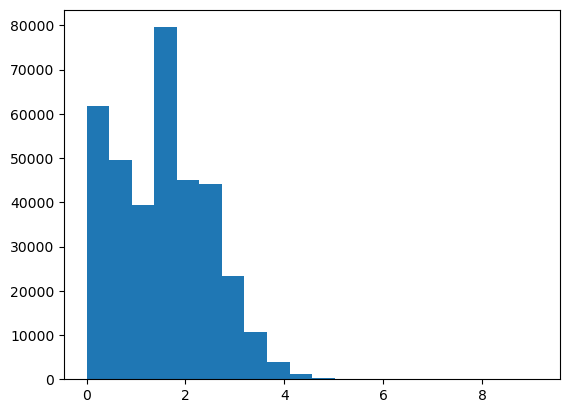

In [59]:
response = full.select('total_sessions_log').toPandas()['total_sessions_log']
plt.hist(response, bins = 20)
plt.show()

In [60]:
# It looks like 300, or ln 5.7, would be a good cutoff to remove extreme outliers. 

In [61]:
# Look at abnormally large number of sessions
#full.select('total_sessions_log').summary().show()

In [62]:
#full.select('total_sessions').sort(desc('total_sessions')).show(50)

In [63]:
# More than 10 sessions a day for a month (300) seems likely to be an error. Removing those rows. 
full = full.filter(col('total_sessions') <= 300)
#full.select('total_sessions').sort(desc('total_sessions')).show(5)
#full.count() #359057

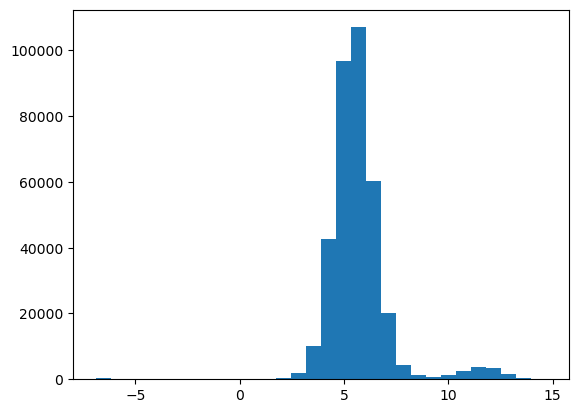

In [64]:
response = full.select('avg_session_length_log').toPandas()['avg_session_length_log']
plt.hist(response, bins = 30)
plt.show()


In [65]:
# It looks like the data here, rather than representing errors, may represent a mixture of two types of consumers - those who leave their session logged in for long periods of time, and those who use it and then log out. 
# All of these times are technically possible. We will not remove.
# February had 29 days in 2020, 2505600 seconds. None of the values exceed that.
#full.select('avg_session_length').sort(desc('avg_session_length')).show(5)

In [66]:
# Look at outliers by total spend. 
full.select('total_spend', 'purchase_events', 'T_total_spend').sort(desc('total_spend')).show(50)
full.select('total_spend').summary().show()

+------------------+---------------+------------------+
|       total_spend|purchase_events|     T_total_spend|
+------------------+---------------+------------------+
|294910.72656440735|            214| 2388.219970703125|
|218647.80018806458|            221|58269.430114746094|
|210609.41940307617|            409| 175792.1243572235|
|166872.38903808594|            257|182246.88173866272|
| 158411.2898645401|            115| 170722.1107711792|
|145547.29903411865|            226|               0.0|
| 142703.8977546692|             91|103079.05834960938|
|141401.14025878906|            291|147372.79080200195|
|124661.77000427246|            244| 97014.05949401855|
|123149.76900672913|             89|111238.14839172363|
|115528.36001586914|            128| 66961.85974121094|
| 102129.9030456543|             77|129897.65153121948|
| 99623.47018814087|            201| 9651.700073242188|
| 95445.87002563477|            132| 76137.35006713867|
| 91185.29978942871|            192| 5125.609909

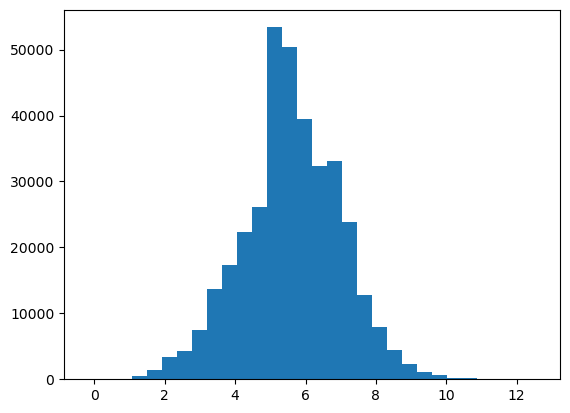

In [67]:
response = full.select('total_spend_log').toPandas()['total_spend_log']
plt.hist(response, bins = 30)
plt.show()


In [68]:
full.select('total_spend_log').summary().show()

+-------+--------------------+
|summary|     total_spend_log|
+-------+--------------------+
|  count|              359057|
|   mean|   5.596129628672631|
| stddev|   1.401201468608159|
|    min|-0.22189431703121995|
|    25%|   4.808935167629805|
|    50%|    5.55055749633489|
|    75%|   6.571304467766164|
|    max|  12.594427971098023|
+-------+--------------------+



In [69]:
## Total spend log is roughly normal. Will not remove outliers. 


#full = full.filter(col('total_spend') <= 100000)
#full.select('total_spend').sort(desc('total_spend')).show(5)
#full.count() #349358

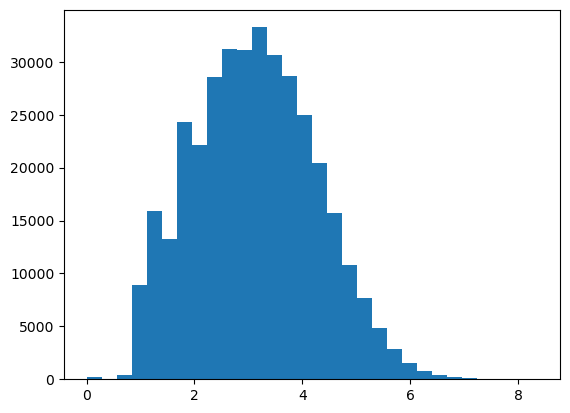

In [70]:
response = full.select('total_events_log').toPandas()['total_events_log']
plt.hist(response, bins = 30)
plt.show()


In [71]:
#full.select('total_events_log').summary().show()

In [72]:
# Look at abnormally large numbers of events
# That's a pretty long tail. Cut it 4 standard deviations above the mean around 7.5, at 2000 events. 
#full.select('total_events').sort(desc('total_events')).show(50)
#full.select('total_events').summary().show()

In [73]:
# Remove extreme> 2000 events a month
full = full.filter(col('total_events') <= 2000)
#full.select('total_events').sort(desc('total_events')).show(5)
#full.count() #359045

#### Save as parquet.

In [74]:
%%time
full.write.mode("overwrite").parquet("./processed_data/engineered_features.parquet")

CPU times: user 4.07 ms, sys: 2.21 ms, total: 6.28 ms
Wall time: 38.4 s


In [75]:
%%time
train, test = full.randomSplit([.8, .2], seed=42)

CPU times: user 0 ns, sys: 1.85 ms, total: 1.85 ms
Wall time: 20.7 ms


#### After building our models using the original data, we became curious about how results would change if we downsampled the 0s in our response variable, since our data is zero-inflated. Below, we'll downsample the data. This new training set will be subbed in for the old, and original test set performance compared. (We have to do the downsampling here because otherwise we might wind up with overlap between it and the original test set.)

In [76]:
%%time
down_0 = train.filter(col('T_total_spend') == 0)
down_1 = train.filter(col('T_total_spend') != 0)

CPU times: user 1.57 ms, sys: 133 µs, total: 1.7 ms
Wall time: 19.5 ms


In [77]:
%%time
#down_0.count()

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.29 µs


In [78]:
%%time
#down_1.count()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


#### Looks like there's about 3x as many 0s as there are non-0s. Downsample to even that out. 

In [79]:
%%time
keep, _ = down_0.randomSplit([.33, .67], seed=42)

CPU times: user 1.7 ms, sys: 0 ns, total: 1.7 ms
Wall time: 10.5 ms


In [80]:
%%time
#keep.count()

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.53 µs


#### Join them back into one dataset

In [81]:
%%time
df_ds = down_1.union(keep)

CPU times: user 0 ns, sys: 714 µs, total: 714 µs
Wall time: 21.2 ms


#### Save as parquet

In [82]:
%%time
df_ds.write.mode("overwrite").parquet("./processed_data/ds_engineered_features.parquet")

CPU times: user 5.96 ms, sys: 1.47 ms, total: 7.43 ms
Wall time: 46.2 s


## Prepare PCA
#### Purchased items in month 1, converted to PCA (pca_purchases)

Note: Unlike all of the other preprocessing, we need to train the PCA model on the training set, then implement it on the test set. For this reason it comes after the train/test split.

In [83]:
%%time

# Create a function that prepares a dataset for PCA.

def pca_prepare_on_subset(subset_df, limited_columns=[]):
    # Only get this data from the training (or test) set
    m1_subset = m1.join(subset_df,'user_id','leftsemi')

    # Remove the periods from the dataframe category_code and replace with dashes. PySpark does not do well with periods in column
    #  names, for some reason
    m1_stripped = m1.withColumn('category_code_s', translate('category_code', '.', '-'))

    # Pivot so that each category of purchase becomes a column. It will have the number of purchases a given person made in that category. 
    cats = m1_stripped.filter(m1.event_type == "purchase").groupBy('user_id').pivot('category_code_s').count().na.fill(0)

    pca_input_cols = [cols for cols in cats.columns if cols!='user_id' and cols!='null']
        
    # Make a new copy of columns (this is from the training set to the test set, in order to filter out other columns)
    if(limited_columns==[]):
        limited_columns = copy.deepcopy(pca_input_cols)
        limited_columns.append('user_id')
    else:
        cats = cats.select(*limited_columns) # This is for the test set 
        # print(cats.schema)

    # Transform columns into a sparse vector (prepare for PCA)
    assembler = VectorAssembler(
        inputCols=pca_input_cols,
        outputCol="to_pca_columns")
    
    # Create sparse vector
    pca_df = assembler.transform(cats)
    return limited_columns, pca_df
    

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


### PCA on Original Data


In [84]:
# Get columns from training set and get training df
limited_columns, train_pre_pca = pca_prepare_on_subset(train)
# Limit to these columns on the test set and get test df
_, test_pre_pca = pca_prepare_on_subset(test, limited_columns=limited_columns)

# Visualize what this looks like
train_pre_pca.select(["user_id","to_pca_columns"]).show(2, truncate=False)

+---------+-----------------------+
|user_id  |to_pca_columns         |
+---------+-----------------------+
|512372691|(135,[0,112],[1.0,1.0])|
|512517137|(135,[85],[1.0])       |
+---------+-----------------------+
only showing top 2 rows



#### k = 10

In [85]:
%%time
# Create new PCA instance
pca = PCAml(k=10, inputCol="to_pca_columns", outputCol="pca_purchases10")
# Fit on training data
model = pca.fit(train_pre_pca)

# Transform training and test sets
train_with_pca = model.transform(train_pre_pca)
test_with_pca = model.transform(test_pre_pca)

# Merge PCA df back into full training set
join_train_df = train_with_pca.select(["user_id","pca_purchases10"])
train = train.join(join_train_df, train.user_id == join_train_df.user_id).drop(join_train_df.user_id)

# Merge PCA df back into full test set
join_test_df = test_with_pca.select(["user_id","pca_purchases10"])
test_o = test.join(join_test_df, test.user_id == join_test_df.user_id).drop(join_test_df.user_id)


CPU times: user 8.67 ms, sys: 2.65 ms, total: 11.3 ms
Wall time: 9.04 s


#### k = 20

In [86]:
%%time
# Create new PCA instance
pca = PCAml(k=20, inputCol="to_pca_columns", outputCol="pca_purchases20")
# Fit on training data
model = pca.fit(train_pre_pca)

# Transform training and test sets
train_with_pca = model.transform(train_pre_pca)
test_with_pca = model.transform(test_pre_pca)

# Merge PCA df back into full training set
join_train_df = train_with_pca.select(["user_id","pca_purchases20"])
train = train.join(join_train_df, train.user_id == join_train_df.user_id).drop(join_train_df.user_id)

# Merge PCA df back into full test set
join_test_df = test_with_pca.select(["user_id","pca_purchases20"])
test_o = test_o.join(join_test_df, test_o.user_id == join_test_df.user_id).drop(join_test_df.user_id)


CPU times: user 5.51 ms, sys: 5.42 ms, total: 10.9 ms
Wall time: 7.17 s


#### k = 50

In [87]:
%%time
# Create new PCA instance
pca = PCAml(k=50, inputCol="to_pca_columns", outputCol="pca_purchases50")
# Fit on training data
model = pca.fit(train_pre_pca)

# Transform training and test sets
train_with_pca = model.transform(train_pre_pca)
test_with_pca = model.transform(test_pre_pca)

# Merge PCA df back into full training set
join_train_df = train_with_pca.select(["user_id","pca_purchases50"])
train = train.join(join_train_df, train.user_id == join_train_df.user_id).drop(join_train_df.user_id)

# Merge PCA df back into full test set
join_test_df = test_with_pca.select(["user_id","pca_purchases50"])
test_o = test_o.join(join_test_df, test_o.user_id == join_test_df.user_id).drop(join_test_df.user_id)


CPU times: user 8.71 ms, sys: 2.17 ms, total: 10.9 ms
Wall time: 7.33 s


#### k = 100

In [88]:
%%time
# Create new PCA instance
pca = PCAml(k=100, inputCol="to_pca_columns", outputCol="pca_purchases100")
# Fit on training data
model = pca.fit(train_pre_pca)

# Transform training and test sets
train_with_pca = model.transform(train_pre_pca)
test_with_pca = model.transform(test_pre_pca)

# Merge PCA df back into full training set
join_train_df = train_with_pca.select(["user_id","pca_purchases100"])
train = train.join(join_train_df, train.user_id == join_train_df.user_id).drop(join_train_df.user_id)

# Merge PCA df back into full test set
join_test_df = test_with_pca.select(["user_id","pca_purchases100"])
test_o = test_o.join(join_test_df, test_o.user_id == join_test_df.user_id).drop(join_test_df.user_id)


CPU times: user 8.74 ms, sys: 2.95 ms, total: 11.7 ms
Wall time: 7.15 s


In [89]:
#train.show(5, truncate=False)
#test_o.show(5, truncate=False)

#### Write train and test

In [90]:
%%time
train.write.mode("overwrite").parquet("./processed_data/train.parquet")
test_o.write.mode("overwrite").parquet("./processed_data/test.parquet")

CPU times: user 12.8 ms, sys: 3.11 ms, total: 15.9 ms
Wall time: 1min 47s


### PCA on Downsampled Data


In [91]:
# Get columns from training set and get training df
limited_columns, train_pre_pca = pca_prepare_on_subset(df_ds)
# Limit to these columns on the test set and get test df
_, test_pre_pca = pca_prepare_on_subset(test, limited_columns=limited_columns)

# Visualize what this looks like
train_pre_pca.select(["user_id","to_pca_columns"]).show(2, truncate=False)

+---------+-----------------------+
|user_id  |to_pca_columns         |
+---------+-----------------------+
|512372691|(135,[0,112],[1.0,1.0])|
|512517137|(135,[85],[1.0])       |
+---------+-----------------------+
only showing top 2 rows



#### k = 10

In [92]:
%%time
# Create new PCA instance
pca = PCAml(k=10, inputCol="to_pca_columns", outputCol="pca_purchases10")
# Fit on training data
model = pca.fit(train_pre_pca)

# Transform training and test sets
train_with_pca = model.transform(train_pre_pca)
test_with_pca = model.transform(test_pre_pca)

# Merge PCA df back into full training set
join_train_df = train_with_pca.select(["user_id","pca_purchases10"])
train_ds = df_ds.join(join_train_df, df_ds.user_id == join_train_df.user_id).drop(join_train_df.user_id)

# Merge PCA df back into full test set
join_test_df = test_with_pca.select(["user_id","pca_purchases10"])
test_ds = test.join(join_test_df, test.user_id == join_test_df.user_id).drop(join_test_df.user_id)


CPU times: user 6.48 ms, sys: 4.4 ms, total: 10.9 ms
Wall time: 7.87 s


#### k = 20

In [93]:
%%time
# Create new PCA instance
pca = PCAml(k=20, inputCol="to_pca_columns", outputCol="pca_purchases20")
# Fit on training data
model = pca.fit(train_pre_pca)

# Transform training and test sets
train_with_pca = model.transform(train_pre_pca)
test_with_pca = model.transform(test_pre_pca)

# Merge PCA df back into full training set
join_train_df = train_with_pca.select(["user_id","pca_purchases20"])
train_ds = train_ds.join(join_train_df, train_ds.user_id == join_train_df.user_id).drop(join_train_df.user_id)

# Merge PCA df back into full test set
join_test_df = test_with_pca.select(["user_id","pca_purchases20"])
test_ds = test_ds.join(join_test_df, test_ds.user_id == join_test_df.user_id).drop(join_test_df.user_id)


CPU times: user 6.81 ms, sys: 3.99 ms, total: 10.8 ms
Wall time: 7.61 s


#### k = 50

In [94]:
%%time
# Create new PCA instance
pca = PCAml(k=50, inputCol="to_pca_columns", outputCol="pca_purchases50")
# Fit on training data
model = pca.fit(train_pre_pca)

# Transform training and test sets
train_with_pca = model.transform(train_pre_pca)
test_with_pca = model.transform(test_pre_pca)

# Merge PCA df back into full training set
join_train_df = train_with_pca.select(["user_id","pca_purchases50"])
train_ds = train_ds.join(join_train_df, train_ds.user_id == join_train_df.user_id).drop(join_train_df.user_id)

# Merge PCA df back into full test set
join_test_df = test_with_pca.select(["user_id","pca_purchases50"])
test_ds = test_ds.join(join_test_df, test_ds.user_id == join_test_df.user_id).drop(join_test_df.user_id)


CPU times: user 8.91 ms, sys: 1.69 ms, total: 10.6 ms
Wall time: 9.84 s


#### k = 100

In [95]:
%%time
# Create new PCA instance
pca = PCAml(k=100, inputCol="to_pca_columns", outputCol="pca_purchases100")
# Fit on training data
model = pca.fit(train_pre_pca)

# Transform training and test sets
train_with_pca = model.transform(train_pre_pca)
test_with_pca = model.transform(test_pre_pca)

# Merge PCA df back into full training set
join_train_df = train_with_pca.select(["user_id","pca_purchases100"])
train_ds = train_ds.join(join_train_df, train_ds.user_id == join_train_df.user_id).drop(join_train_df.user_id)

# Merge PCA df back into full test set
join_test_df = test_with_pca.select(["user_id","pca_purchases100"])
test_ds = test_ds.join(join_test_df, test_ds.user_id == join_test_df.user_id).drop(join_test_df.user_id)


CPU times: user 10.2 ms, sys: 890 µs, total: 11.1 ms
Wall time: 7.21 s


In [96]:
#train_ds.show(1, truncate=False)
#test_ds.show(1, truncate=False)

### Write downsampled train and test

In [97]:
%%time
train_ds.write.mode("overwrite").parquet("./processed_data/ds_train.parquet")
test_ds.write.mode("overwrite").parquet("./processed_data/ds_test.parquet")

CPU times: user 10.2 ms, sys: 4.76 ms, total: 14.9 ms
Wall time: 1min 51s
